In [1]:
from datetime import datetime
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from tqdm.auto import tqdm

from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
from PIL import Image
from IPython.display import display

In [2]:
def show_tensor_images(image_tensor, num_images=1, size=(1, 256, 512)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [17]:
class ThinningNet(Module):
    def __init__(self):
        
        super(ThinningNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)
        self.relu1 = ReLU()
        
        self.conv2 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)
        self.relu2 = ReLU()      
      
        self.conv3 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)
        self.relu3 = ReLU()
        
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)   
                          
        return self.sigmoid(x)

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)

model=ThinningNet().to(device)
model  

cuda


ThinningNet(
  (conv1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (sigmoid): Sigmoid()
)

In [51]:
#training model
INIT_LR = 1e-2
BATCH_SIZE = 4
EPOCHS = 100

lossFn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=INIT_LR)

data_dir ='./dataset/'

trainTransforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

trainDataset = ImageFolder(os.path.join(data_dir,'train'), transform = trainTransforms)
trainDataLoader = DataLoader(trainDataset, batch_size=BATCH_SIZE,shuffle=True)

trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE

print('Length train:',len(trainDataLoader.dataset))
print('BATCH_SIZE',BATCH_SIZE)
print('trainSteps:',trainSteps)
  
cost_list=[]

print('\nBegin trainning ...\n')
startTime = time.time()

for e in range(0,EPOCHS):
    #train model
    model.train()
    
    print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
   
    totalTrainLoss = 0
    
    for image, _ in tqdm(trainDataLoader):
        
        im_width =  image.shape[2]
        
        real_input  = image[:, :, :im_width // 2]
        real_output = image[:, :, im_width // 2:]
            
        real_input = real_input.to(device)
        real_output = real_output.to(device)
            
        output = model(real_input)
        loss = lossFn(output, real_output)
            
        opt.zero_grad()
        loss.backward() 
        opt.step()
        
        totalTrainLoss += loss.item()
      
    avgTrainLoss = totalTrainLoss / trainSteps
    #avgTrainLoss = totalTrainLoss
    
    cost_list.append(avgTrainLoss) 
       
    
    print("Train loss in epoch {} is {}".format(e+1,avgTrainLoss))
    print("========================================================")

endTime = time.time()

print("Total time taken to train the model: {:.2f}s".format(endTime - startTime))

now = datetime.now()
date_time = now.strftime("%Y%m%d_%H%M%S")

str =  "\n{} Loss after {} epoch: {}, min loss = {}".format(date_time,e+1,cost_list[e], min(cost_list))  
print(str)
text_file = open("loss-stat.txt", "a")
n = text_file.write(str)
text_file.close()

Length train: 155
BATCH_SIZE 4
trainSteps: 38

Begin trainning ...

[INFO] EPOCH: 1/100



Train loss in epoch 1 is 0.03131988757338963
[INFO] EPOCH: 2/100



Train loss in epoch 2 is 0.031081954728027706
[INFO] EPOCH: 3/100



Train loss in epoch 3 is 0.031263975328520724
[INFO] EPOCH: 4/100



Train loss in epoch 4 is 0.03113174634544473
[INFO] EPOCH: 5/100



Train loss in epoch 5 is 0.030989109097342742
[INFO] EPOCH: 6/100



Train loss in epoch 6 is 0.031043961546138713
[INFO] EPOCH: 7/100



Train loss in epoch 7 is 0.03097063021146153
[INFO] EPOCH: 8/100



Train loss in epoch 8 is 0.03088039723470023
[INFO] EPOCH: 9/100



Train loss in epoch 9 is 0.030934692262426802
[INFO] EPOCH: 10/100



Train loss in epoch 10 is 0.03096086551484309
[INFO] EPOCH: 11/100



Train loss in epoch 11 is 0.030739109374974902
[INFO] EPOCH: 12/100



Train loss in epoch 12 is 0.030739652336035903
[INFO] EPOCH: 13/100



Train loss in epoch 13 is 0.0311782019163825
[INFO] EPOCH: 14/100



Train loss in epoch 14 is 0.030919528615317847
[INFO] EPOCH: 15/100



Train loss in epoch 15 is 0.03071460546925664
[INFO] EPOCH: 16/100



Train loss in epoch 16 is 0.03092108936490197
[INFO] EPOCH: 17/100



Train loss in epoch 17 is 0.030992725398391485
[INFO] EPOCH: 18/100



Train loss in epoch 18 is 0.030877271176953065
[INFO] EPOCH: 19/100



Train loss in epoch 19 is 0.030760528470732663
[INFO] EPOCH: 20/100



Train loss in epoch 20 is 0.030586231720486756
[INFO] EPOCH: 21/100



Train loss in epoch 21 is 0.03064151993021369
[INFO] EPOCH: 22/100



Train loss in epoch 22 is 0.03069032826705983
[INFO] EPOCH: 23/100



Train loss in epoch 23 is 0.03075087889048614
[INFO] EPOCH: 24/100



Train loss in epoch 24 is 0.030820043610506935
[INFO] EPOCH: 25/100



Train loss in epoch 25 is 0.030691971806319135
[INFO] EPOCH: 26/100



Train loss in epoch 26 is 0.030676552388621003
[INFO] EPOCH: 27/100



Train loss in epoch 27 is 0.030719840016804244
[INFO] EPOCH: 28/100



Train loss in epoch 28 is 0.030675359854572697
[INFO] EPOCH: 29/100



Train loss in epoch 29 is 0.030760902298712416
[INFO] EPOCH: 30/100



Train loss in epoch 30 is 0.030695158498067605
[INFO] EPOCH: 31/100



Train loss in epoch 31 is 0.030648545999276012
[INFO] EPOCH: 32/100



Train loss in epoch 32 is 0.03053833475630534
[INFO] EPOCH: 33/100



Train loss in epoch 33 is 0.030743083696028118
[INFO] EPOCH: 34/100



Train loss in epoch 34 is 0.030703529519470113
[INFO] EPOCH: 35/100



Train loss in epoch 35 is 0.030523621403661213
[INFO] EPOCH: 36/100



Train loss in epoch 36 is 0.030656783351380574
[INFO] EPOCH: 37/100



Train loss in epoch 37 is 0.030646445523751408
[INFO] EPOCH: 38/100



Train loss in epoch 38 is 0.03061588750661988
[INFO] EPOCH: 39/100



Train loss in epoch 39 is 0.030630604020859067
[INFO] EPOCH: 40/100



Train loss in epoch 40 is 0.03051955221024783
[INFO] EPOCH: 41/100



Train loss in epoch 41 is 0.030646269381242364
[INFO] EPOCH: 42/100



Train loss in epoch 42 is 0.030652190558612347
[INFO] EPOCH: 43/100



Train loss in epoch 43 is 0.030711748343157142
[INFO] EPOCH: 44/100



Train loss in epoch 44 is 0.030699465203246002
[INFO] EPOCH: 45/100



Train loss in epoch 45 is 0.030722712044064935
[INFO] EPOCH: 46/100



Train loss in epoch 46 is 0.030730011186709528
[INFO] EPOCH: 47/100



Train loss in epoch 47 is 0.030616566440776774
[INFO] EPOCH: 48/100



Train loss in epoch 48 is 0.03064655573842557
[INFO] EPOCH: 49/100



Train loss in epoch 49 is 0.03073920444340298
[INFO] EPOCH: 50/100



Train loss in epoch 50 is 0.030538336177797692
[INFO] EPOCH: 51/100



Train loss in epoch 51 is 0.0305645384972817
[INFO] EPOCH: 52/100



Train loss in epoch 52 is 0.0305639364217457
[INFO] EPOCH: 53/100



Train loss in epoch 53 is 0.03065898266964053
[INFO] EPOCH: 54/100



Train loss in epoch 54 is 0.0305135564780549
[INFO] EPOCH: 55/100



Train loss in epoch 55 is 0.030845482294496736
[INFO] EPOCH: 56/100



Train loss in epoch 56 is 0.030593626985424442
[INFO] EPOCH: 57/100



Train loss in epoch 57 is 0.030752933902764006
[INFO] EPOCH: 58/100



Train loss in epoch 58 is 0.03063549157722216
[INFO] EPOCH: 59/100



Train loss in epoch 59 is 0.030528849260391372
[INFO] EPOCH: 60/100



Train loss in epoch 60 is 0.030739913547509594
[INFO] EPOCH: 61/100



Train loss in epoch 61 is 0.030571751468079656
[INFO] EPOCH: 62/100



Train loss in epoch 62 is 0.030766735539624567
[INFO] EPOCH: 63/100



Train loss in epoch 63 is 0.030714047656051423
[INFO] EPOCH: 64/100



Train loss in epoch 64 is 0.030584288859053663
[INFO] EPOCH: 65/100



Train loss in epoch 65 is 0.030585681137285735
[INFO] EPOCH: 66/100



Train loss in epoch 66 is 0.030639563736162688
[INFO] EPOCH: 67/100



Train loss in epoch 67 is 0.030667079808680636
[INFO] EPOCH: 68/100



Train loss in epoch 68 is 0.030830992042626206
[INFO] EPOCH: 69/100



Train loss in epoch 69 is 0.030698807272864014
[INFO] EPOCH: 70/100



Train loss in epoch 70 is 0.031085511228363765
[INFO] EPOCH: 71/100



Train loss in epoch 71 is 0.03073331294581294
[INFO] EPOCH: 72/100



Train loss in epoch 72 is 0.030704165147127288
[INFO] EPOCH: 73/100



Train loss in epoch 73 is 0.03056620522157142
[INFO] EPOCH: 74/100



Train loss in epoch 74 is 0.030699204923094886
[INFO] EPOCH: 75/100



Train loss in epoch 75 is 0.030954023798633563
[INFO] EPOCH: 76/100



Train loss in epoch 76 is 0.030754402819040575
[INFO] EPOCH: 77/100



Train loss in epoch 77 is 0.03061061676003431
[INFO] EPOCH: 78/100



Train loss in epoch 78 is 0.03063179822148461
[INFO] EPOCH: 79/100



Train loss in epoch 79 is 0.0305669774595452
[INFO] EPOCH: 80/100



Train loss in epoch 80 is 0.030507296862963
[INFO] EPOCH: 81/100



Train loss in epoch 81 is 0.030502941630976766
[INFO] EPOCH: 82/100



Train loss in epoch 82 is 0.030598105225515992
[INFO] EPOCH: 83/100



Train loss in epoch 83 is 0.030678642815665194
[INFO] EPOCH: 84/100



Train loss in epoch 84 is 0.030521046002640537
[INFO] EPOCH: 85/100



Train loss in epoch 85 is 0.030618543981721525
[INFO] EPOCH: 86/100



Train loss in epoch 86 is 0.030631797608772392
[INFO] EPOCH: 87/100



Train loss in epoch 87 is 0.030738908282824252
[INFO] EPOCH: 88/100



Train loss in epoch 88 is 0.030533192189116227
[INFO] EPOCH: 89/100



Train loss in epoch 89 is 0.030634545010367508
[INFO] EPOCH: 90/100



Train loss in epoch 90 is 0.030549506362723678
[INFO] EPOCH: 91/100



Train loss in epoch 91 is 0.03054996329898897
[INFO] EPOCH: 92/100



Train loss in epoch 92 is 0.03068346922334872
[INFO] EPOCH: 93/100



Train loss in epoch 93 is 0.03062921818835955
[INFO] EPOCH: 94/100



Train loss in epoch 94 is 0.030493658232061488
[INFO] EPOCH: 95/100



Train loss in epoch 95 is 0.030549228338426666
[INFO] EPOCH: 96/100



Train loss in epoch 96 is 0.030818481586481396
[INFO] EPOCH: 97/100



Train loss in epoch 97 is 0.03096084683937462
[INFO] EPOCH: 98/100



Train loss in epoch 98 is 0.030683102968492006
[INFO] EPOCH: 99/100



Train loss in epoch 99 is 0.030657046327465458
[INFO] EPOCH: 100/100



Train loss in epoch 100 is 0.030476182012965803
Total time taken to train the model: 396.66s

20211118_154711 Loss after 100 epoch: 0.030476182012965803, min loss = 0.030476182012965803


Loss after 100 epoch: 0.030476182012965803, min loss = 0.030476182012965803


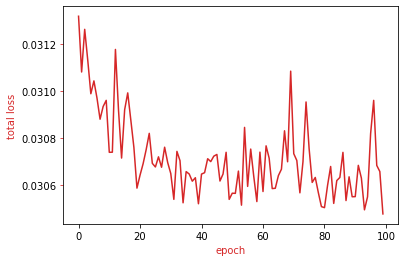

In [52]:
print("Loss after {} epoch: {}, min loss = {}".format(e+1,cost_list[e], min(cost_list)))

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)

In [53]:
torch.save(model, "./output/{}_thinner_{:.4f}.pth".format(date_time,cost_list[e]))

Output real:


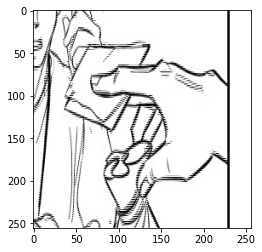

===
Output model predict:


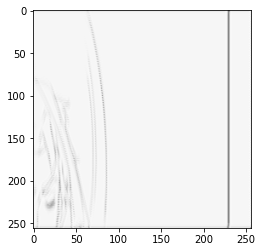

In [54]:
testTransforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

testDataset = ImageFolder(os.path.join(data_dir,'test'), transform = trainTransforms)
testDataLoader = DataLoader(valDataset, batch_size=1,shuffle=True)

torch.no_grad()
load_path ='./output/20211118_154711_thinner_0.0305.pth'

model = torch.load(load_path)
model.eval()

for image, _ in tqdm(testDataLoader):        
    im_width =  image.shape[2]        
    real_input  = image[:, :, :im_width // 2]
    real_output = image[:, :, im_width // 2:]
            
    real_input = real_input.to(device)
    real_output = real_output.to(device)
            
    output = model(real_input)
    print('Output real:')
    show_tensor_images(real_output,1,(1, 256, 256))
    print('===')
    print('Output model predict:')
    show_tensor_images(output,1,(1, 256, 256))

In [45]:
'''
path ='./dataset/test/3/'
img_names = []

for folder,subfolders,filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+img)
        #print(img_names)

pic = 0

img_test = Image.open(img_names[pic])

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

im = transform(img_test)

im_width =  im.shape[2]

im_input  = im[:, :, :im_width // 2]
im_output = im[:, :, im_width // 2:]

show_tensor_images(im,1,(1, 256, 256))

show_tensor_images(im_input,1,(1, 256, 256))
show_tensor_images(im_output,1,(1, 256, 256))
'''

"\npath ='./dataset/test/3/'\nimg_names = []\n\nfor folder,subfolders,filenames in os.walk(path):\n    for img in filenames:\n        img_names.append(folder+img)\n        #print(img_names)\n\npic = 0\n\nimg_test = Image.open(img_names[pic])\n\ntransform = transforms.Compose([\n    transforms.Grayscale(num_output_channels=1),\n    transforms.ToTensor()\n])\n\nim = transform(img_test)\n\nim_width =  im.shape[2]\n\nim_input  = im[:, :, :im_width // 2]\nim_output = im[:, :, im_width // 2:]\n\nshow_tensor_images(im,1,(1, 256, 256))\n\nshow_tensor_images(im_input,1,(1, 256, 256))\nshow_tensor_images(im_output,1,(1, 256, 256))\n"